In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [2]:
train = pd.read_csv("../data/raw/non_rand_discount.csv",sep=";")
test = pd.read_csv("../data/raw/random_data.csv")

In [3]:
# defining a function that replaces US$ for nothing in order to get rid of the non-numerical values
def remove_symbols(discount):
  return float(discount.replace('US$ ', '')) 

In [4]:
train.discount = train.discount.apply(remove_symbols)

In [5]:
train_two = train[['sales','discount','profit','age','cust_state','tenure','sales_prediction_bins','sales_prediction']]
train_two.head()

,sales,discount,profit,age,cust_state,tenure,sales_prediction_bins,sales_prediction
0,3368.64,125.0,40.06,40,MA,6,8,1351.024765
1,2133.10,75.0,29.52,36,MG,10,4,1035.580387
2,2001.62,50.0,48.08,34,RJ,7,3,992.401825
3,1461.96,10.0,61.64,31,BA,7,1,919.720735
4,2743.72,100.0,34.44,32,PB,6,6,1176.485681


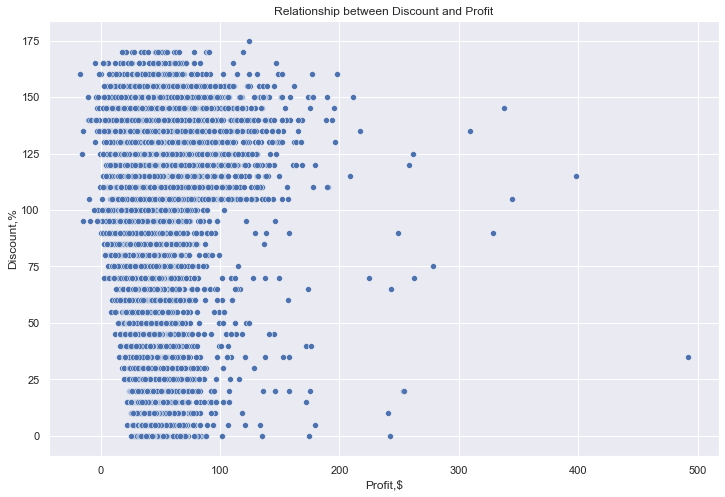

In [6]:
# relationship between discount and profit for the train df
plt.figure(figsize=(12,8))
sns.scatterplot(x="profit", y="discount",data=train)
plt.ylabel('Discount,%')
plt.xlabel('Profit,$')
plt.title('Relationship between Discount and Profit')
plt.show()

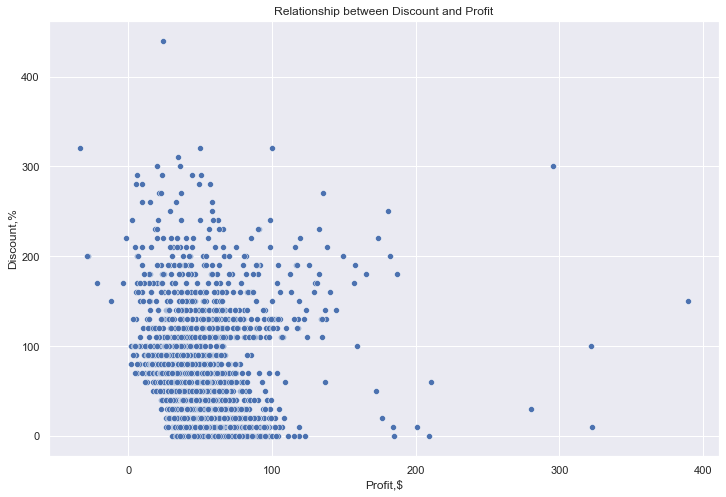

In [7]:
# relationship between discount and profit for the test df
plt.figure(figsize=(12,8))
sns.scatterplot(x="profit", y="discount",data=test)
plt.ylabel('Discount,%')
plt.xlabel('Profit,$')
plt.title('Relationship between Discount and Profit')
plt.show()

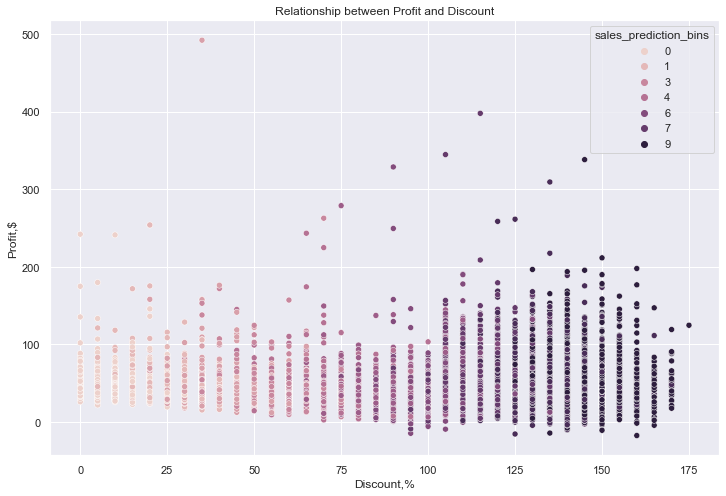

In [8]:
# plot of profit by the discount, color represents sales_prediction_bin
plt.figure(figsize=(12,8))
sns.scatterplot(x="discount", y="profit", hue="sales_prediction_bins",data=train)
plt.ylabel('Profit,$')
plt.xlabel('Discount,%')
plt.title('Relationship between Profit and Discount')
plt.show()



In [9]:
# 2.1.1
# regression of profits on discount
mod = smf.ols(formula='profit ~ discount + sales_prediction_bins', data=train_two)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     167.1
Date:                Sun, 24 Jul 2022   Prob (F-statistic):           1.65e-72
Time:                        17:17:35   Log-Likelihood:                -68380.
No. Observations:               15000   AIC:                         1.368e+05
Df Residuals:                   14997   BIC:                         1.368e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                39.98

B1 = -0.0172

In [10]:
# 2.1.2
# regression of discount on sales_prediction_bins
debias_model = smf.ols(formula='discount ~ sales_prediction_bins', data=train_two)
debias_model = debias_model.fit()
train_two['discount_residual'] = train_two['discount'] - debias_model.predict(train_two['sales_prediction_bins'])
train_two.head()

,sales,discount,profit,age,cust_state,tenure,sales_prediction_bins,sales_prediction,discount_residual
0,3368.64,125.0,40.06,40,MA,6,8,1351.024765,-5.000377
1,2133.10,75.0,29.52,36,MG,10,4,1035.580387,4.694547
2,2001.62,50.0,48.08,34,RJ,7,3,992.401825,-5.381722
3,1461.96,10.0,61.64,31,BA,7,1,919.720735,-15.534259
4,2743.72,100.0,34.44,32,PB,6,6,1176.485681,-0.152915


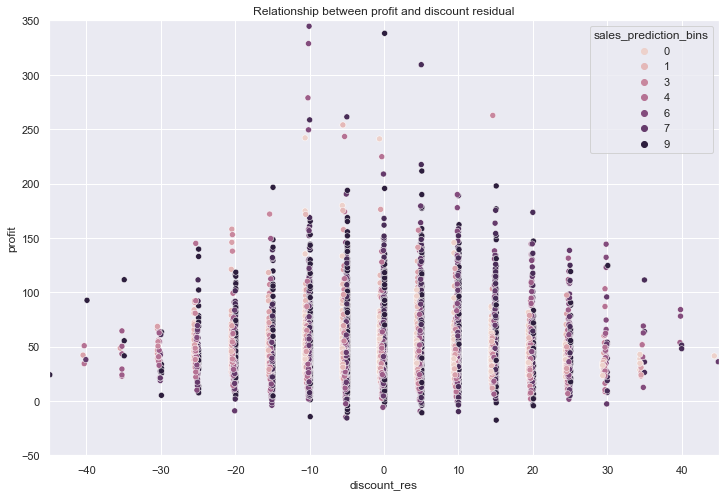

In [11]:
plt.figure(figsize=(12,8))
sns.scatterplot(x="discount_residual", y="profit", hue="sales_prediction_bins",data=train_two)
plt.ylabel('profit')
plt.xlabel('discount_res')
plt.ylim([-50, 350])
plt.xlim([-45, 45])
plt.title('Relationship between profit and discount residual')
plt.show()

In [12]:
# 2.1.3
# regression of discount on sales_prediction_bins
denoise_model = smf.ols(formula='profit ~ sales_prediction_bins', data=train_two)
denoise_model = denoise_model.fit()
train_two['profit_residual'] = train_two['profit'] - denoise_model.predict(train_two['sales_prediction_bins'])
train_two.head()

,sales,discount,profit,age,cust_state,tenure,sales_prediction_bins,sales_prediction,discount_residual,profit_residual
0,3368.64,125.0,40.06,40,MA,6,8,1351.024765,-5.000377,-9.336232
1,2133.10,75.0,29.52,36,MG,10,4,1035.580387,4.694547,-15.081671
2,2001.62,50.0,48.08,34,RJ,7,3,992.401825,-5.381722,4.676969
3,1461.96,10.0,61.64,31,BA,7,1,919.720735,-15.534259,20.634250
4,2743.72,100.0,34.44,32,PB,6,6,1176.485681,-0.152915,-12.558952


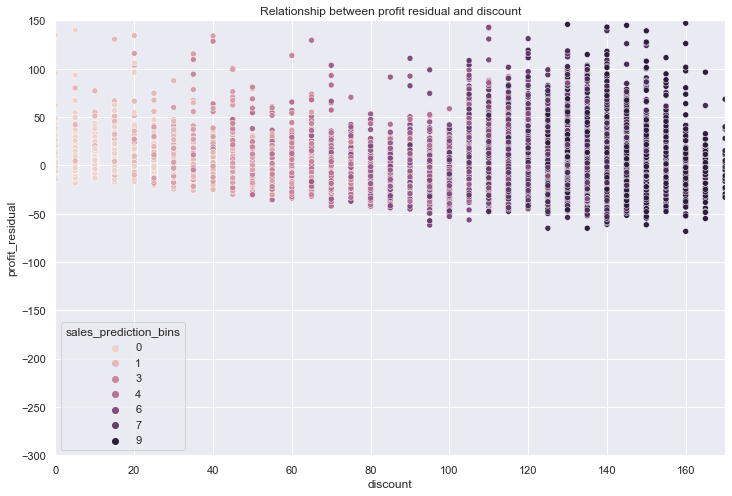

In [13]:
plt.figure(figsize=(12,8))
sns.scatterplot(x="discount", y="profit_residual", hue="sales_prediction_bins",data=train_two)
plt.ylabel('profit_residual')
plt.xlabel('discount')
plt.ylim([-300, 150])
plt.xlim([0, 170])
plt.title('Relationship between profit residual and discount')
plt.show()

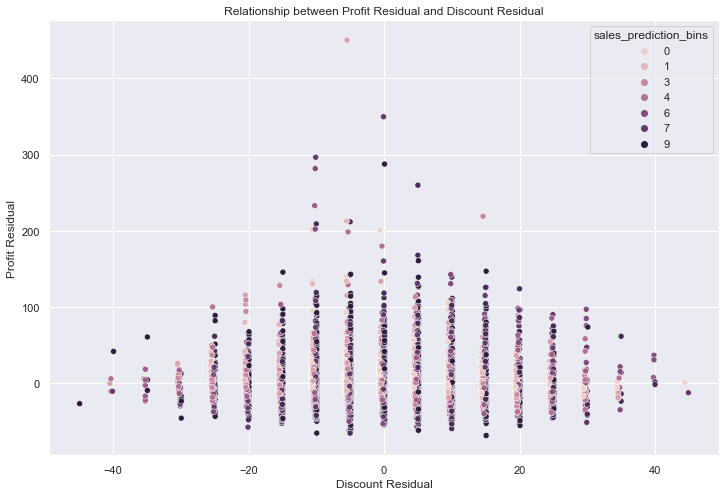

In [16]:
# 2.1.4
plt.figure(figsize=(12,8))
sns.scatterplot(x="discount_residual", y="profit_residual", hue="sales_prediction_bins",data=train_two)
plt.ylabel('Profit Residual')
plt.xlabel('Discount Residual')
plt.title('Relationship between Profit Residual and Discount Residual')
plt.show()


In [17]:
model = smf.ols(formula='profit_residual ~ discount_residual', data=train_two)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        profit_residual   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9976
Date:                Sun, 24 Jul 2022   Prob (F-statistic):              0.318
Time:                        17:23:10   Log-Likelihood:                -68380.
No. Observations:               15000   AIC:                         1.368e+05
Df Residuals:                   14998   BIC:                         1.368e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          9.048e-15      0.189    4.8e-14      1.000      -0.370       0.370
discount_residual    -0.0172      0.017     -0.999      0.318      -0.051       0.017
==============================================================================
Omnibus:                    11165.900   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           515520.223
Skew:                           3.114   Prob(JB):                         0.00
Kurtosis:                      31.036   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 3.1.1
state_sales_train = train_two.groupby(['cust_state'])['sales'].mean().to_dict()
state_sales_test = test.groupby(['cust_state'])['sales'].mean().to_dict()

In [ ]:
#def state_to_numeric(cust_state,sales):
#    return 
train_remapped = train_two.replace({"cust_state": state_sales_train})
test_remapped = test.replace({"cust_state": state_sales_test})

In [ ]:
train_remapped

In [ ]:
# 3.1.2
y = train_remapped['discount']
x = train_remapped[['cust_state']]

In [ ]:
model = LinearRegression()
scores = cross_val_score(model, x, y, cv=5, scoring = 'r2')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
model.fit(x, y)

In [ ]:
train_remapped

In [ ]:
train_remapped['discount_res'] = train_remapped['discount'] - model.predict(train_remapped[['cust_state']])
train_remapped

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x="discount_res", y="profit", hue="sales_prediction_bins",data=train_remapped)
plt.ylabel('Profit,$')
plt.xlabel('Discount Residuals,%')
plt.title('Relationship between Profit and Discount Residuals')
plt.show()


In [ ]:
# random_forest.fit(x, y)
# pred = random_forest.predict(X_test) 

In [ ]:
# profit vs discount_res

In [ ]:
# 3.1.2

In [ ]:
y = train_remapped['profit']
x = train_remapped[['cust_state', 'tenure','age','sales_prediction']]

In [ ]:
model = LinearRegression()
scores = cross_val_score(model, x, y, cv=5, scoring='r2')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
model.fit(x, y)